In [112]:
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [195]:
fakes_path = Path("results/clipping_frame24_iterD2_alphaSimil0_seed7879_220608-085346/fakes")
reals_path = Path("results/clipping_frame24_iterD2_alphaSimil0_seed7879_220608-085346/reals")

In [223]:
padding = 2
rows = 2
columns = 24
img_size = 256
frame = 5
bins = 200

In [224]:
def H(img, bins):
    img = np.asanyarray(img)
    img = (img - img.min()) / (img.max() - img.min())
    img = 0.21 * img[..., 0] + 0.72 * img[..., 1] + 0.07 * img[..., 2]

    bin_counts, bin_edges = np.histogram(img.ravel(), bins)
    bin_counts = bin_counts / bin_counts.sum()

    return bin_counts

In [225]:
def calc_similarity(data_path):
    films = []
    for path in data_path.iterdir():
        image = Image.open(path)
        for r in range(rows):
            images = []
            for c in range(columns):
                p = padding
                size_col = p + (img_size + p) * c
                size_row = p + (img_size + p) * r
                images.append(image.crop((size_col, size_row, size_col + img_size, size_row + img_size)))
            films.append(images)

    similarities = []
    for images in films:
        img0 = images[0]
        h0 = H(img0, bins)
        s = []
        for t in range(len(images)):
            imgt = images[t]
            ht = H(imgt, bins)
            st = np.sum(np.min(np.stack([h0, ht]), axis=0))
            s.append(st)
        similarities.append(s)
    similarities = np.array(similarities)

    e, nf = similarities.shape
    value = similarities.ravel()
    element_idx = np.arange(nf).repeat(e).reshape(nf, -1).T.flatten()

    df = pd.DataFrame({"Color similarity": value, "Frame separation": element_idx})
    return df

In [226]:
fakes_df = calc_similarity(fakes_path)
reals_df = calc_similarity(reals_path)
fakes_df["Fake"] = "Generated"
reals_df["Fake"] = "Dataset"

In [227]:
sim_df = pd.concat([fakes_df, reals_df]).reset_index()

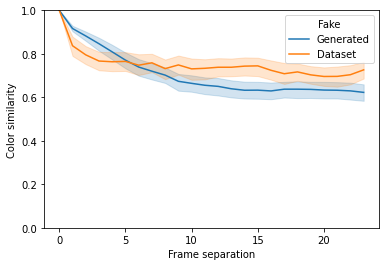

In [228]:
ax = plt.subplot(111)

sns.lineplot(data=sim_df, x="Frame separation", y="Color similarity", hue="Fake")
ax.set_ylim(0, 1)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


In [156]:
img = np.asanyarray(images[0])
img = (img - img.min()) / (img.max() - img.min())
img = 0.21 * img[..., 0] + 0.72 * img[..., 1] + 0.07 * img[..., 2]

In [159]:
img0 = images[0]
h0 = H(img0, bins)
s = []
for t in range(len(images)):
    imgt = images[t]
    ht = H(imgt, bins)
    st = np.sum(np.min(np.stack([h0, ht]), axis=0))
    s.append(st)

Text(0, 0.5, 'Color similarity')

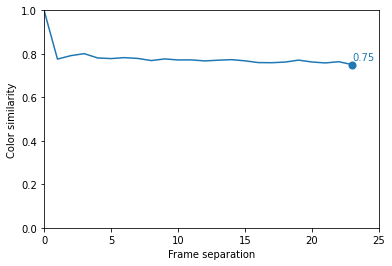

In [167]:
ax = plt.subplot(111)

ax.plot(np.arange(len(s)), s, c="tab:blue")
ax.scatter(len(s)-1, s[-1], s=50, c="tab:blue")
ax.annotate(f"{s[-1]:.2}", (len(s)-1+0.02, s[-1]+0.02), c="tab:blue")
ax.set_ylim(0, 1)
ax.set_xlim(0, len(s)+1)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_xlabel("Frame separation")
ax.set_ylabel("Color similarity")